In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'ON Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Manulife Financial Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,2.0
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,2.0
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,2.0
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,2.0
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,1.0


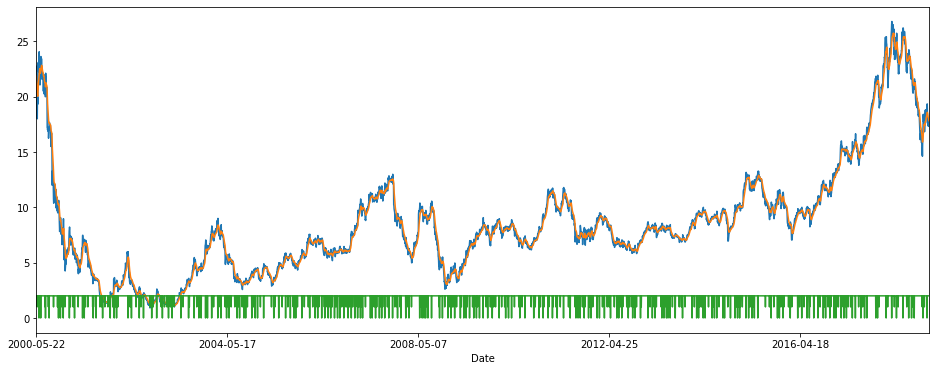

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [8]:
willr_data = np.array(willr_data)
willr_data.shape

(4661, 15, 1)

In [9]:
price_data = np.array(price_data)
price_data.shape

(4661, 15, 1)

In [10]:
ema_data = np.array(ema_data)
ema_data.shape

(4661, 15, 1)

In [11]:
obv_data = np.array(obv_data)
obv_data.shape

(4661, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4661, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({0.0: 198, 2.0: 4263, 1.0: 200})

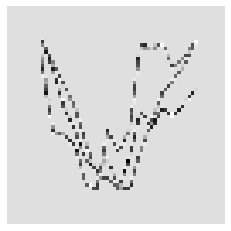

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.3815 - accuracy: 0.6562 - mse: 5.5153 - weighted_accuracy: 0.3350 - weighted_mse: 5.6028WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 23ms/step - loss: 0.2386 - accuracy: 0.4410 - mse: 1.5372 - weighted_accuracy: 0.3087 - weighted_mse: 1.6160 - val_loss: 0.1927 - val_accuracy: 0.8424 - val_mse: 0.9103 - val_weighted_accuracy: 0.8424 - val_weighted_mse: 0.9103
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2059 - accuracy: 0.3342 - mse: 1.1591 - weighted_accuracy: 0.3193 - weighted_mse: 1.1876 - val_loss: 0.2118 - val_accuracy: 0.0439 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.2363 - mse: 1.2103 - weighted_accuracy: 0.3998 - weighted_mse: 1.1836 - val_loss: 0.1725 - val_accuracy: 0.8489 - val_mse: 0.9433 - val_weighted_accuracy: 0.8489 - val_weighted_mse: 0.9433
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.3106 - mse: 1.2134 - weighted_accuracy: 0.4129 - weighted_mse: 1.2070 - val_loss: 0.1941 - val_accuracy: 0.3055 - val_mse: 0.9662 - val_weighted_accuracy: 0.3055 - val_weighted_mse: 0.9662
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.2715 - mse: 1.2000 - weighted_accuracy: 0.4265 - weighted_mse: 1.1846 - val_loss: 0.1922 - val_accuracy: 0.1147 - val_mse: 0.9681 - val_weighted_accuracy: 0.1147 - val_weighted_mse: 0.9681
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.2575 - mse: 1.2169 - weighted_accuracy: 0.4254 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1758 - accuracy: 0.1725 - mse: 1.2547 - weighted_accuracy: 0.5268 - weighted_mse: 1.2178 - val_loss: 0.1981 - val_accuracy: 0.1190 - val_mse: 1.0638 - val_weighted_accuracy: 0.1190 - val_weighted_mse: 1.0638
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1716 - accuracy: 0.1757 - mse: 1.3314 - weighted_accuracy: 0.5600 - weighted_mse: 1.2869 - val_loss: 0.1978 - val_accuracy: 0.1200 - val_mse: 1.1301 - val_weighted_accuracy: 0.1200 - val_weighted_mse: 1.1301
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1765 - accuracy: 0.1655 - mse: 1.3376 - weighted_accuracy: 0.5164 - weighted_mse: 1.2718 - val_loss: 0.1978 - val_accuracy: 0.1318 - val_mse: 1.1447 - val_weighted_accuracy: 0.1318 - val_weighted_mse: 1.1447
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1720 - accuracy: 0.1639 - mse: 1.3213 - weighted_accuracy: 0.5415 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1557 - accuracy: 0.2052 - mse: 1.4576 - weighted_accuracy: 0.6184 - weighted_mse: 1.4727 - val_loss: 0.1959 - val_accuracy: 0.1983 - val_mse: 1.3455 - val_weighted_accuracy: 0.1983 - val_weighted_mse: 1.3455
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1508 - accuracy: 0.2197 - mse: 1.5182 - weighted_accuracy: 0.6340 - weighted_mse: 1.5206 - val_loss: 0.1964 - val_accuracy: 0.2262 - val_mse: 1.4125 - val_weighted_accuracy: 0.2262 - val_weighted_mse: 1.4125
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1554 - accuracy: 0.2130 - mse: 1.5388 - weighted_accuracy: 0.6252 - weighted_mse: 1.5280 - val_loss: 0.1966 - val_accuracy: 0.2176 - val_mse: 1.3658 - val_weighted_accuracy: 0.2176 - val_weighted_mse: 1.3658
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1541 - accuracy: 0.2116 - mse: 1.5105 - weighted_accuracy: 0.6089 - weig

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1380 - accuracy: 0.3112 - mse: 1.7585 - weighted_accuracy: 0.6952 - weighted_mse: 1.8449 - val_loss: 0.1904 - val_accuracy: 0.3012 - val_mse: 1.5516 - val_weighted_accuracy: 0.3012 - val_weighted_mse: 1.5516
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1379 - accuracy: 0.3053 - mse: 1.7493 - weighted_accuracy: 0.6809 - weighted_mse: 1.8617 - val_loss: 0.1881 - val_accuracy: 0.3087 - val_mse: 1.5342 - val_weighted_accuracy: 0.3087 - val_weighted_mse: 1.5342
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1387 - accuracy: 0.3095 - mse: 1.7140 - weighted_accuracy: 0.6885 - weighted_mse: 1.8123 - val_loss: 0.1882 - val_accuracy: 0.2958 - val_mse: 1.4863 - val_weighted_accuracy: 0.2958 - val_weighted_mse: 1.4863
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1408 - accuracy: 0.3173 - mse: 1.6752 - weighted_accuracy: 0.6753 - 

Epoch 143/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.4160 - mse: 1.9930 - weighted_accuracy: 0.7391 - weighted_mse: 2.3164 - val_loss: 0.1729 - val_accuracy: 0.4630 - val_mse: 1.6784 - val_weighted_accuracy: 0.4630 - val_weighted_mse: 1.6784
Epoch 144/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.4348 - mse: 2.0253 - weighted_accuracy: 0.7460 - weighted_mse: 2.4383 - val_loss: 0.1742 - val_accuracy: 0.4405 - val_mse: 1.6683 - val_weighted_accuracy: 0.4405 - val_weighted_mse: 1.6683
Epoch 145/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1219 - accuracy: 0.4394 - mse: 2.0437 - weighted_accuracy: 0.7576 - weighted_mse: 2.4669 - val_loss: 0.1752 - val_accuracy: 0.4394 - val_mse: 1.7170 - val_weighted_accuracy: 0.4394 - val_weighted_mse: 1.7170
Epoch 146/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1278 - accuracy: 0.4308 - mse: 2.0291 - weighted_accuracy: 0.734

Epoch 172/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1140 - accuracy: 0.5628 - mse: 2.4357 - weighted_accuracy: 0.8067 - weighted_mse: 3.1219 - val_loss: 0.1569 - val_accuracy: 0.5895 - val_mse: 1.9625 - val_weighted_accuracy: 0.5895 - val_weighted_mse: 1.9625
Epoch 173/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1136 - accuracy: 0.5550 - mse: 2.4209 - weighted_accuracy: 0.7977 - weighted_mse: 3.1871 - val_loss: 0.1542 - val_accuracy: 0.6249 - val_mse: 2.1049 - val_weighted_accuracy: 0.6249 - val_weighted_mse: 2.1049
Epoch 174/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1115 - accuracy: 0.5475 - mse: 2.4986 - weighted_accuracy: 0.7970 - weighted_mse: 3.3488 - val_loss: 0.1563 - val_accuracy: 0.6131 - val_mse: 2.1718 - val_weighted_accuracy: 0.6131 - val_weighted_mse: 2.1718
Epoch 175/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1149 - accuracy: 0.5542 - mse: 2.5220 - weighted_accuracy: 0.781

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13787846267223358
Test accuracy: 0.715969979763031


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.0239198  -1.4697603  -0.37936366]
 [-1.4462665  -1.5708646  -0.31893817]
 [-1.5214545  -1.3564975  -0.16524598]
 ...
 [-2.1368499  -0.99608564 -0.2751957 ]
 [-0.9505738  -1.9668621  -0.34459662]
 [-2.3499193  -0.7309053  -0.27794576]]


Counter({2: 714, 0: 100, 1: 119})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 853, 0: 40, 1: 40})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 933
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 31
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 32
actual holds but predicted buy: 110
actual holds but predicted sell: 92
actual predicted holds: 651
Percentage buys correct: 22.5%
Percentage sells correct: 20.0%
Percentage holds correct: 76.31887456037515%
actual buys: 40
actual sells: 40
actual holds: 853


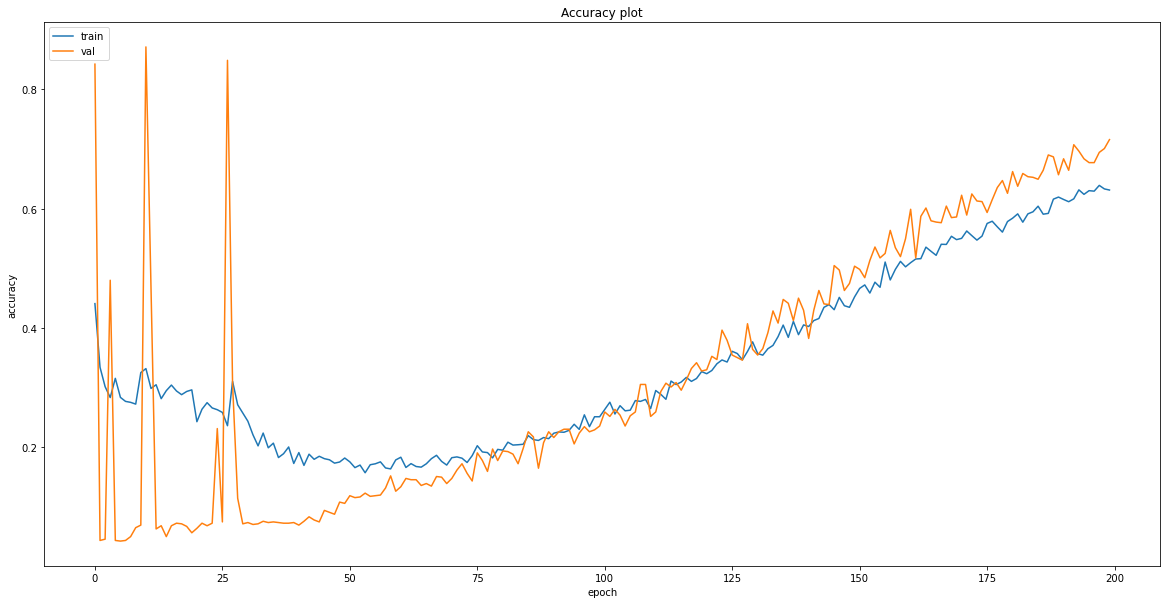

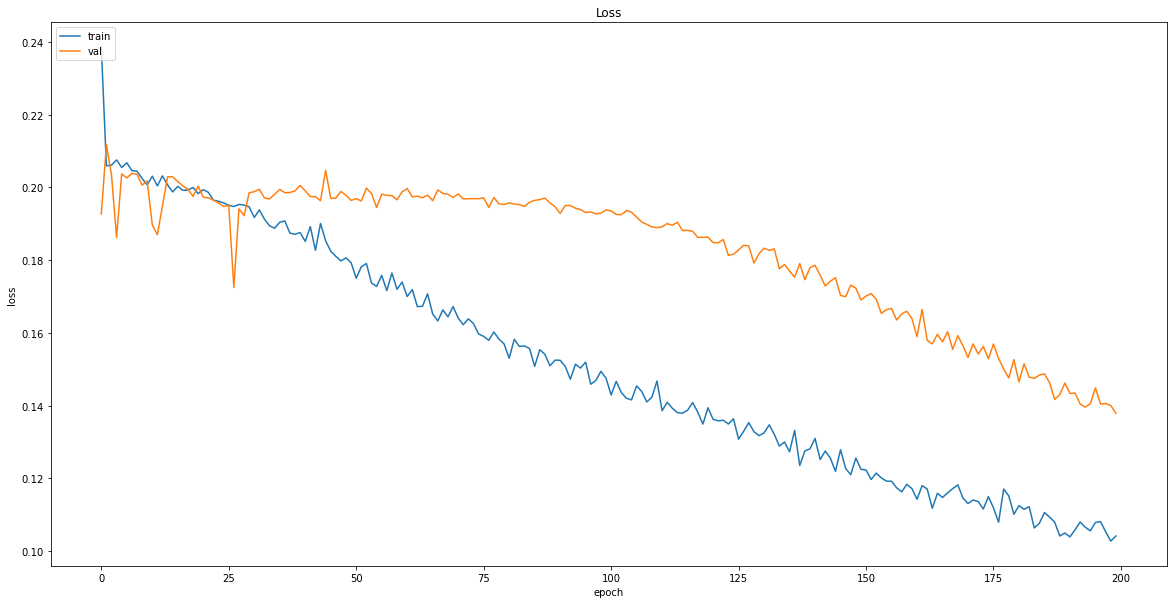

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('ON_no_support_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/ON_no_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,18.410000,17.463881,-16.959062,38067400.0,2.0
2019-01-23,17.760000,17.509437,-35.964898,32120500.0,1.0
2019-01-24,17.610001,17.524909,-40.350852,27571200.0,2.0
2019-01-25,18.990000,17.750307,-5.688638,39283300.0,2.0
2019-01-28,20.120001,18.114876,-3.499985,49475700.0,2.0


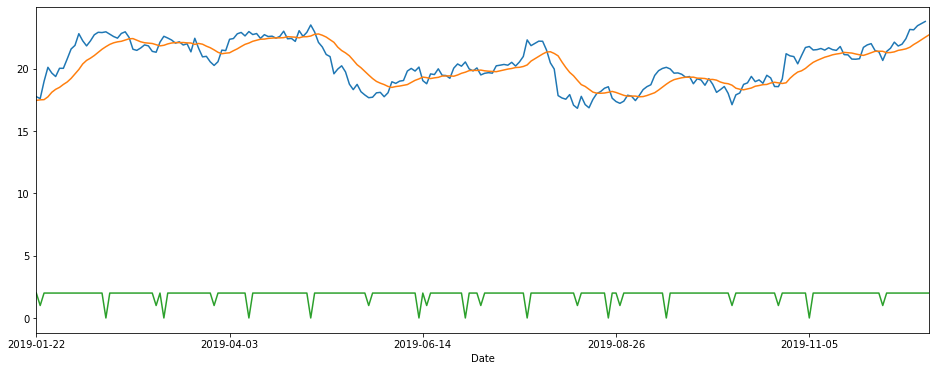

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/ON_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1374 - accuracy: 0.7339 - mean_squared_error: 2.4100 - weighted_accuracy: 0.7339 - weighted_mean_squared_error: 2.4100
Test loss: 0.13740411400794983
Test accuracy: 0.7339449524879456


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 17, 2: 178, 0: 23})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [40]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,22.240000,20.853401,-24.835530,80357300.0,2.0,1,2
2019-02-12,22.730000,21.066723,-18.256589,87641400.0,2.0,2,2
2019-02-13,22.930000,21.322612,-11.610502,92339900.0,2.0,0,2
2019-02-14,22.910000,21.569903,-9.790209,98060800.0,2.0,2,2
2019-02-15,22.969999,21.776071,-10.731719,93565600.0,0.0,2,0


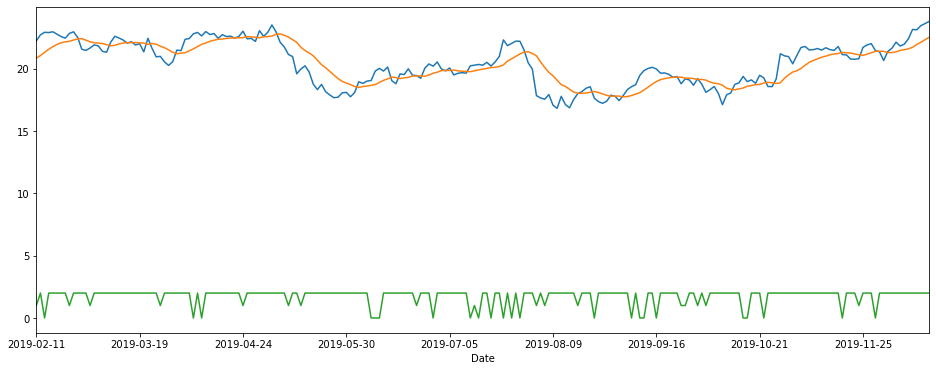

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

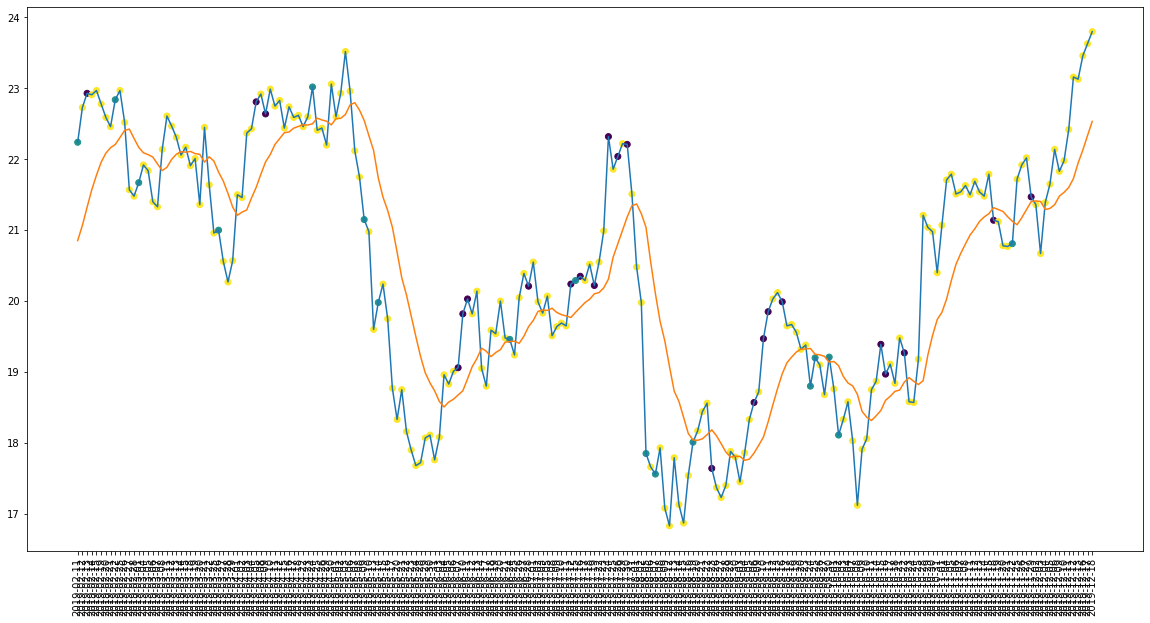

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

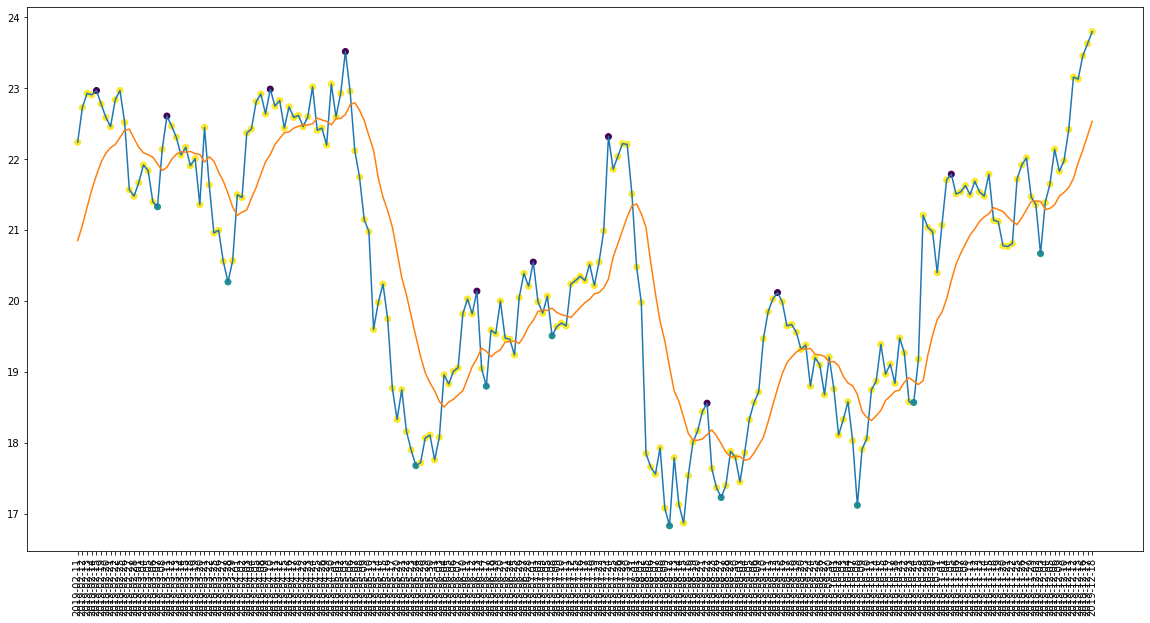

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 22
actual predicted holds: 159
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 80.3030303030303%
actual buys: 10
actual sells: 10
actual holds: 198


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[22.239999771118164, 22.459999084472656, 22.59000015258789, 22.729999542236328, 22.78000068664551, 22.84000015258789, 22.90999984741211, 22.93000030517578, 22.96999931335449]
[21.479999542236328, 21.56999969482422, 21.670000076293945, 21.920000076293945, 22.459999084472656, 22.520000457763672, 22.59000015258789, 22.84000015258789, 22.96999931335449]
Percentage buys correct: 41.1764705882353%
Percentage sells correct: 56.52173913043478%
Percentage holds correct: 83.05084745762711%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $22.239999771118164
Shares owned at the moment: 448
Cash capital at the moment: $9.080422821045431


Stop Loss Activated!

Share price: $21.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9645.866046478272


Share price: $21.670000076293945
Shares owned at the moment: 443
Cash capital at the moment: $19.65653508710784


Stop Loss Activated!

Share price: $20.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $9279.401610623836


Share price: $21.0
Shares owned at the moment: 440
Cash capital at the moment: $13.991610623836095


Stop Loss Activated!

Share price: $20.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $8908.265111485958


Share price: $23.020000457763672
Shares owned at the moment: 385
Cash capital at the moment: $21.192509762286136


Stop Loss Activated!

Share price: $22.200000762939453
Shares owned at the moment: 0
Cash capital at the moment: $8544.688552686213


Share price: $21.1499

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10642.158481964114
profit gained: 6.421584819641139%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,0.0%,10.0%,80.3030303030303%,41.1764705882353%,56.52173913043478%,83.05084745762711%,-21.51396943860532%,6.421584819641139%


### Recession test data

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


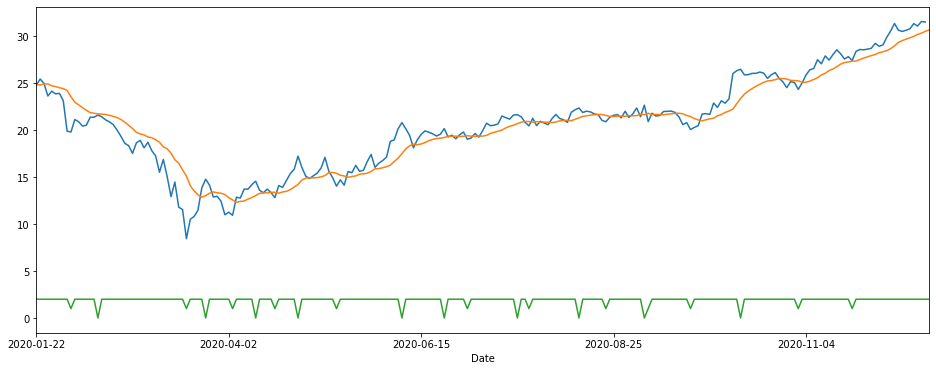

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/ON_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 11ms/step - loss: 0.1482 - accuracy: 0.7032 - mean_squared_error: 2.4843 - weighted_accuracy: 0.7032 - weighted_mean_squared_error: 2.4843
Test loss: 0.14818823337554932
Test accuracy: 0.7031963467597961


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 1: 24, 0: 27})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,21.400000,21.887629,-80.763353,-38050800.0,2.0,2,2
2020-02-12,21.389999,21.812609,-67.633600,-29835300.0,2.0,2,2
2020-02-13,21.629999,21.747592,-67.786276,-35158900.0,0.0,2,0
2020-02-14,21.440001,21.729501,-53.280337,-29027400.0,2.0,2,2
2020-02-18,21.110001,21.684962,-57.057647,-34656200.0,2.0,2,2


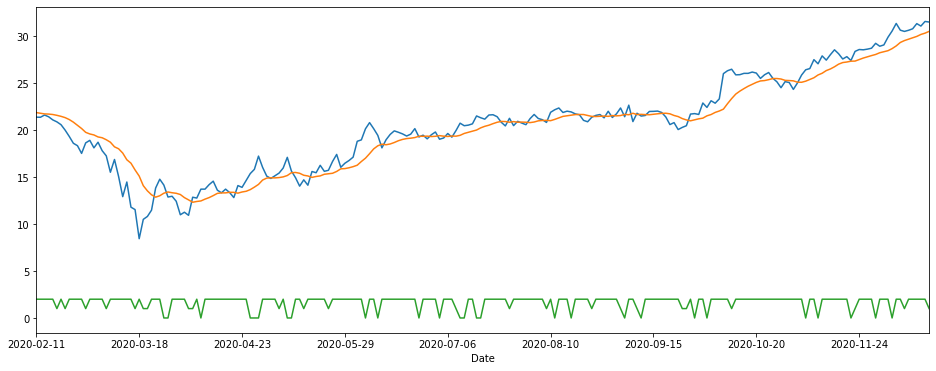

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

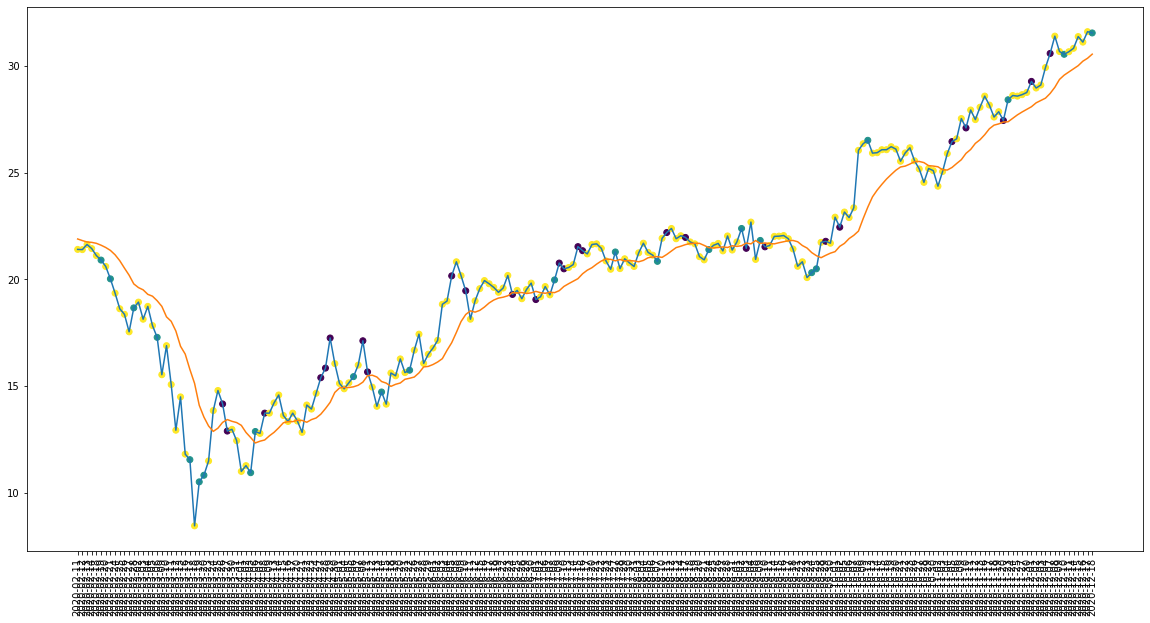

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

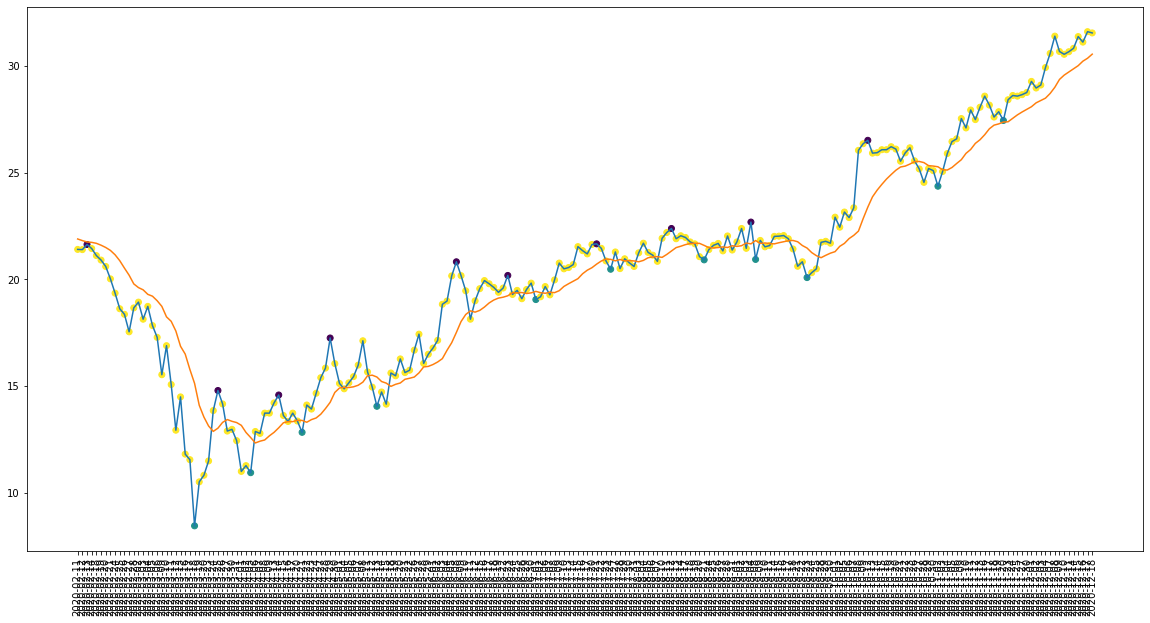

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 24
actual predicted holds: 152
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 10.0%
Percentage holds correct: 76.76767676767676%
actual buys: 11
actual sells: 10
actual holds: 198


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[19.350000381469727, 20.020000457763672, 20.600000381469727, 20.899999618530273, 21.11000061035156, 21.38999938964844, 21.399999618530273, 21.440000534057614, 21.6299991607666]
[17.540000915527347, 18.1299991607666, 18.36000061035156, 18.6200008392334, 18.65999984741211, 18.93000030517578, 19.350000381469727, 20.020000457763672, 20.600000381469727]
Percentage buys correct: 45.833333333333336%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 82.63473053892216%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $20.899999618530273
Shares owned at the moment: 477
Cash capital at the moment: $3.284607461451742


Stop Loss Activated!

Share price: $20.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9526.563590214251


Share price: $20.020000457763672
Shares owned at the moment: 474
Cash capital at the moment: $10.98730263757534


Stop Loss Activated!

Share price: $19.350000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9157.66475795698


Share price: $18.65999984741211
Shares owned at the moment: 489
Cash capital at the moment: $7.831797777651445


Stop Loss Activated!

Share price: $18.1299991607666
Shares owned at the moment: 0
Cash capital at the moment: $8849.021071021078


Share price: $17.280000686645508
Shares owned at the moment: 510
Cash capital at the moment: $11.985519868847405


Stop Loss Activated!

Share price: $15.529999732971193
Shares owned at the moment: 0
Cash capital at the moment: $7910.504559058663


Share price

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $14657.397993716238
profit gained: 46.573979937162385%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,0.0%,10.0%,80.3030303030303%,41.1764705882353%,56.52173913043478%,83.05084745762711%,-21.51396943860532%,6.421584819641139%
1,0.703196,9.090909090909092%,10.0%,76.76767676767676%,45.833333333333336%,55.55555555555556%,82.63473053892216%,51.19968491929272%,46.573979937162385%


### with TSM stock price

In [71]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,2.0
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,2.0
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,2.0
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,2.0
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,1.0


In [72]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,19.949877,19.054130,-24.858793,6410264.0,2.0
2000-01-24,20.708067,19.308582,-12.499994,8519498.0,2.0
2000-01-25,22.627235,19.819144,-9.615394,11923394.0,2.0
2000-01-26,24.830727,20.590156,-1.204825,15511940.0,2.0
2000-01-27,23.977762,21.111327,-32.407403,8331683.0,2.0


In [73]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,2.0,18.105579
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,2.0,17.468700
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,2.0,16.831820
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,2.0,16.012976
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,1.0,16.043303


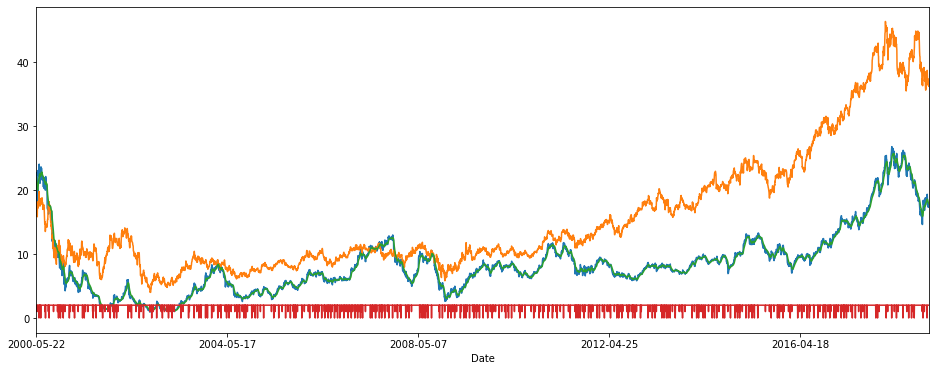

In [74]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [75]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [77]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4661, 64, 64, 1)

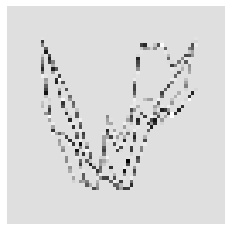

In [78]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [79]:
X = X/255

In [80]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [81]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [84]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}
Epoch 1/200
30/30 [==============================] - 2s 64ms/step - loss: 0.2427 - accuracy: 0.4590 - mse: 1.5260 - weighted_accuracy: 0.3191 - weighted_mse: 1.6083 - val_loss: 0.1678 - val_accuracy: 0.9143 - val_mse: 0.7943 - val_weighted_accuracy: 0.9143 - val_weighted_mse: 0.7943
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2114 - accuracy: 0.5373 - mse: 1.0953 - weighted_accuracy: 0.3238 - weighted_mse: 1.1590 - val_loss: 0.1960 - val_accuracy: 0.0932 - val_mse: 0.8192 - val_weighted_accuracy: 0.0932 - val_weighted_mse: 0.8192
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2061 - accuracy: 0.5239 - mse: 1.1094 - weighted_accuracy: 0.3286 - weighted_mse: 1.1559 - val_loss: 0.1814 - val_accuracy: 0.9143 - val_mse: 0.8518 - val_weighted_accuracy: 0.9143 - val_weighted_mse: 0.8518
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2068 

30/30 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.3152 - mse: 1.1755 - weighted_accuracy: 0.4164 - weighted_mse: 1.1651 - val_loss: 0.1957 - val_accuracy: 0.1522 - val_mse: 0.9504 - val_weighted_accuracy: 0.1522 - val_weighted_mse: 0.9504
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1969 - accuracy: 0.3176 - mse: 1.1644 - weighted_accuracy: 0.3915 - weighted_mse: 1.1541 - val_loss: 0.1987 - val_accuracy: 0.0697 - val_mse: 0.9340 - val_weighted_accuracy: 0.0697 - val_weighted_mse: 0.9340
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1961 - accuracy: 0.3112 - mse: 1.2123 - weighted_accuracy: 0.3847 - weighted_mse: 1.2060 - val_loss: 0.1962 - val_accuracy: 0.0686 - val_mse: 0.9420 - val_weighted_accuracy: 0.0686 - val_weighted_mse: 0.9420
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1944 - accuracy: 0.3106 - mse: 1.1725 - weighted_accuracy: 0.4027 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1794 - accuracy: 0.2280 - mse: 1.2539 - weighted_accuracy: 0.4908 - weighted_mse: 1.2325 - val_loss: 0.1904 - val_accuracy: 0.1758 - val_mse: 1.0678 - val_weighted_accuracy: 0.1758 - val_weighted_mse: 1.0678
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1808 - accuracy: 0.2454 - mse: 1.2732 - weighted_accuracy: 0.4833 - weighted_mse: 1.2257 - val_loss: 0.1896 - val_accuracy: 0.2004 - val_mse: 1.0307 - val_weighted_accuracy: 0.2004 - val_weighted_mse: 1.0307
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1776 - accuracy: 0.2221 - mse: 1.2958 - weighted_accuracy: 0.4927 - weighted_mse: 1.2527 - val_loss: 0.1894 - val_accuracy: 0.2047 - val_mse: 1.1472 - val_weighted_accuracy: 0.2047 - val_weighted_mse: 1.1472
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.2216 - mse: 1.2901 - weighted_accuracy: 0.4966 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1533 - accuracy: 0.2575 - mse: 1.4615 - weighted_accuracy: 0.5995 - weighted_mse: 1.4386 - val_loss: 0.1926 - val_accuracy: 0.2186 - val_mse: 1.3419 - val_weighted_accuracy: 0.2186 - val_weighted_mse: 1.3419
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1517 - accuracy: 0.2591 - mse: 1.5233 - weighted_accuracy: 0.6199 - weighted_mse: 1.5186 - val_loss: 0.1979 - val_accuracy: 0.1854 - val_mse: 1.3299 - val_weighted_accuracy: 0.1854 - val_weighted_mse: 1.3299
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1535 - accuracy: 0.2613 - mse: 1.4846 - weighted_accuracy: 0.5887 - weighted_mse: 1.4605 - val_loss: 0.1817 - val_accuracy: 0.3269 - val_mse: 1.3168 - val_weighted_accuracy: 0.3269 - val_weighted_mse: 1.3168
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1532 - accuracy: 0.2916 - mse: 1.4326 - weighted_accuracy: 0.6257 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1313 - accuracy: 0.4067 - mse: 1.8750 - weighted_accuracy: 0.6896 - weighted_mse: 1.9863 - val_loss: 0.1713 - val_accuracy: 0.4609 - val_mse: 1.6358 - val_weighted_accuracy: 0.4609 - val_weighted_mse: 1.6358
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1296 - accuracy: 0.4222 - mse: 1.8979 - weighted_accuracy: 0.7013 - weighted_mse: 2.0016 - val_loss: 0.1690 - val_accuracy: 0.4759 - val_mse: 1.6173 - val_weighted_accuracy: 0.4759 - val_weighted_mse: 1.6173
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.4295 - mse: 1.8749 - weighted_accuracy: 0.7018 - weighted_mse: 2.0262 - val_loss: 0.1754 - val_accuracy: 0.4255 - val_mse: 1.6953 - val_weighted_accuracy: 0.4255 - val_weighted_mse: 1.6953
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1316 - accuracy: 0.3780 - mse: 1.8892 - weighted_accuracy: 0.6871 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1117 - accuracy: 0.5306 - mse: 2.2133 - weighted_accuracy: 0.7566 - weighted_mse: 2.6870 - val_loss: 0.1484 - val_accuracy: 0.6324 - val_mse: 1.8581 - val_weighted_accuracy: 0.6324 - val_weighted_mse: 1.8581
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1108 - accuracy: 0.5376 - mse: 2.3019 - weighted_accuracy: 0.7592 - weighted_mse: 2.7839 - val_loss: 0.1482 - val_accuracy: 0.6442 - val_mse: 1.8699 - val_weighted_accuracy: 0.6442 - val_weighted_mse: 1.8699
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1169 - accuracy: 0.5604 - mse: 2.1401 - weighted_accuracy: 0.7434 - weighted_mse: 2.4344 - val_loss: 0.1653 - val_accuracy: 0.5380 - val_mse: 1.9455 - val_weighted_accuracy: 0.5380 - val_weighted_mse: 1.9455
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1082 - accuracy: 0.5451 - mse: 2.2762 - weighted_accuracy: 0.7759 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1010 - accuracy: 0.6298 - mse: 2.5448 - weighted_accuracy: 0.7708 - weighted_mse: 3.2949 - val_loss: 0.1281 - val_accuracy: 0.7621 - val_mse: 2.0286 - val_weighted_accuracy: 0.7621 - val_weighted_mse: 2.0286
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0973 - accuracy: 0.6288 - mse: 2.5099 - weighted_accuracy: 0.7845 - weighted_mse: 3.2900 - val_loss: 0.1370 - val_accuracy: 0.6795 - val_mse: 2.2037 - val_weighted_accuracy: 0.6795 - val_weighted_mse: 2.2037
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0977 - accuracy: 0.6347 - mse: 2.6474 - weighted_accuracy: 0.7946 - weighted_mse: 3.2486 - val_loss: 0.1313 - val_accuracy: 0.7524 - val_mse: 2.0072 - val_weighted_accuracy: 0.7524 - val_weighted_mse: 2.0072
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0965 - accuracy: 0.6532 - mse: 2.5595 - weighted_accuracy: 0.7772 - 

In [85]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11685102432966232
Test accuracy: 0.7888531684875488


In [86]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.8738426  -1.5698777  -0.04387733]
 [-1.6075263  -1.6151187   0.16177976]
 [-1.6335325  -1.013641    0.03646413]
 ...
 [-2.7016058  -0.58187133 -0.29732853]
 [-0.6076982  -2.9250457  -0.187257  ]
 [-2.3371487  -0.8319651  -0.1038879 ]]


Counter({2: 780, 1: 115, 0: 38})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 853, 0: 40, 1: 40})

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 933
actual predicted buys: 15
actual buys but predicted sell: 0
actual buys but predicted hold: 25
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 37
actual holds but predicted buy: 100
actual holds but predicted sell: 35
actual predicted holds: 718
Percentage buys correct: 37.5%
Percentage sells correct: 7.5%
Percentage holds correct: 84.17350527549824%
actual buys: 40
actual sells: 40
actual holds: 853


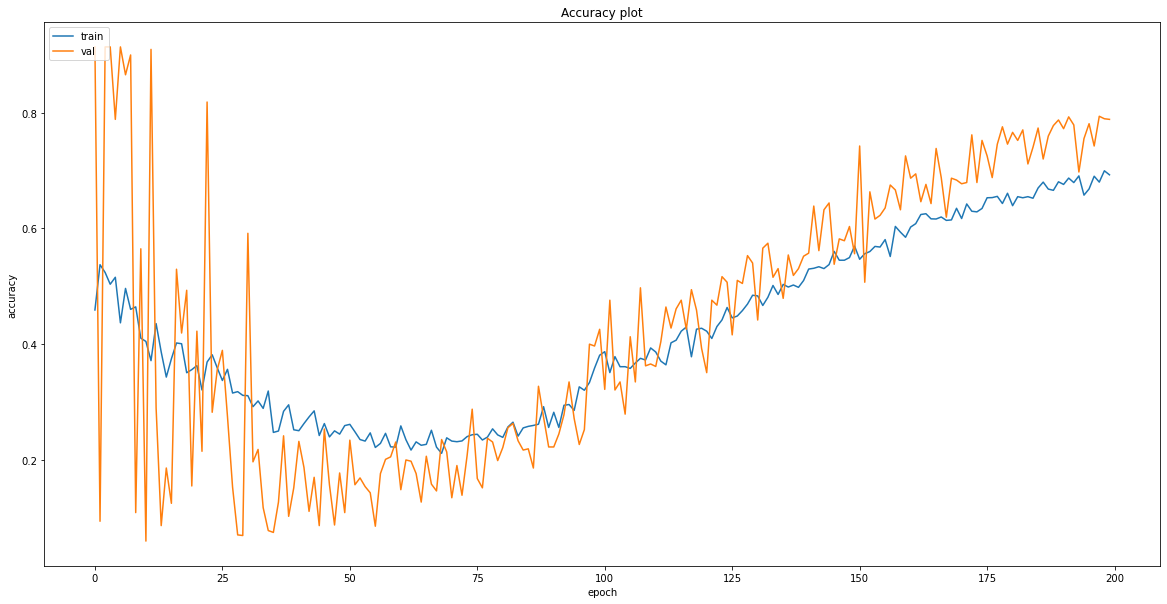

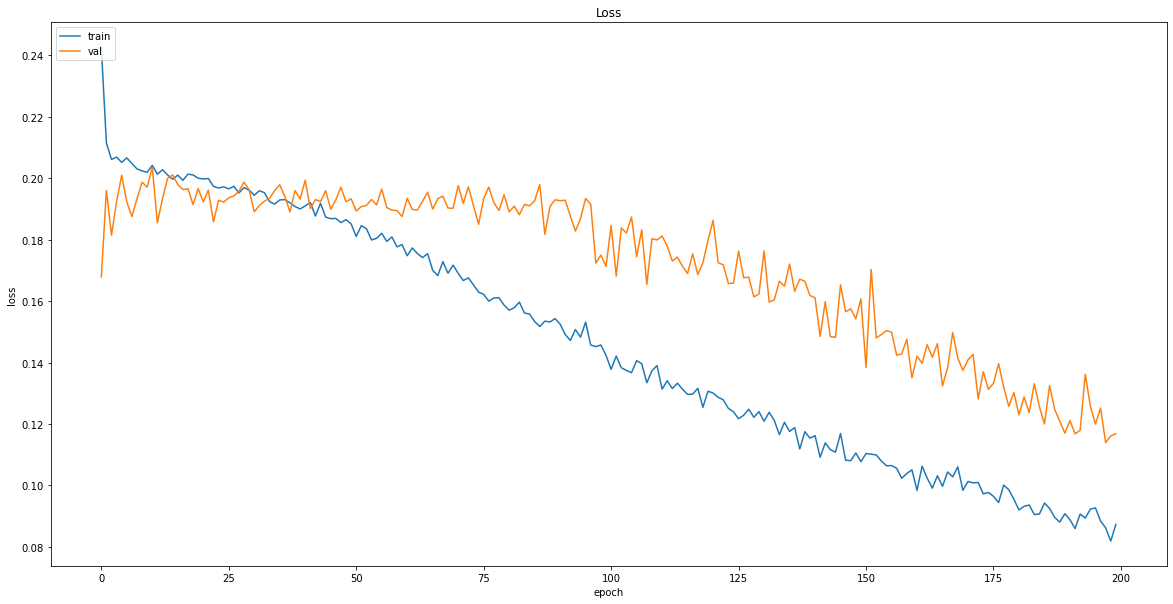

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Save model
model.save("models/{}".format('ON_support_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/ON_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [91]:
logger = []

In [92]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0


In [93]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,36.840000,35.988585,-22.189342,49908500.0,2.0
2019-01-23,36.369999,36.047264,-22.857127,36526800.0,2.0
2019-01-24,36.490002,36.115377,-18.571314,50445400.0,2.0
2019-01-25,37.639999,36.349935,-0.000000,64539500.0,2.0
2019-01-28,38.139999,36.625329,-3.314889,81303200.0,2.0


In [94]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2019-01-22,18.410000,17.463881,-16.959062,38067400.0,2.0,36.840000
2019-01-23,17.760000,17.509437,-35.964898,32120500.0,1.0,36.369999
2019-01-24,17.610001,17.524909,-40.350852,27571200.0,2.0,36.490002
2019-01-25,18.990000,17.750307,-5.688638,39283300.0,2.0,37.639999
2019-01-28,20.120001,18.114876,-3.499985,49475700.0,2.0,38.139999


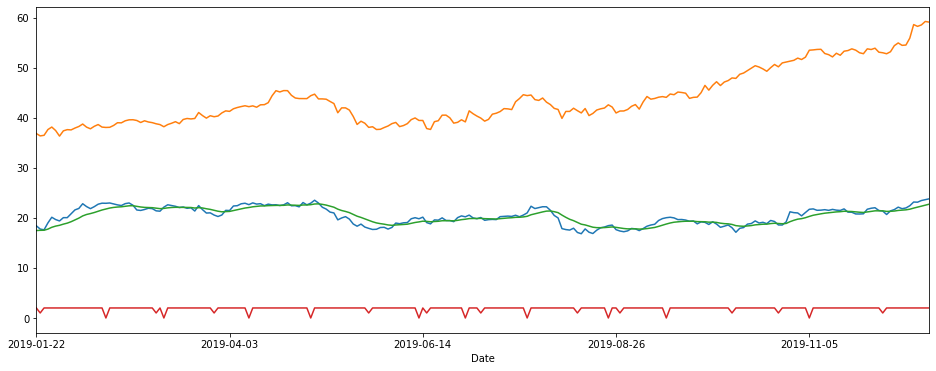

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/ON_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.7706 - mean_squared_error: 2.4325 - weighted_accuracy: 0.7706 - weighted_mean_squared_error: 2.4325
Test loss: 0.12364836037158966
Test accuracy: 0.7706422209739685


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 1: 23, 0: 15})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [103]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,22.240000,20.853401,-24.835530,80357300.0,2.0,2,2
2019-02-12,22.730000,21.066723,-18.256589,87641400.0,2.0,2,2
2019-02-13,22.930000,21.322612,-11.610502,92339900.0,2.0,2,2
2019-02-14,22.910000,21.569903,-9.790209,98060800.0,2.0,2,2
2019-02-15,22.969999,21.776071,-10.731719,93565600.0,0.0,2,0


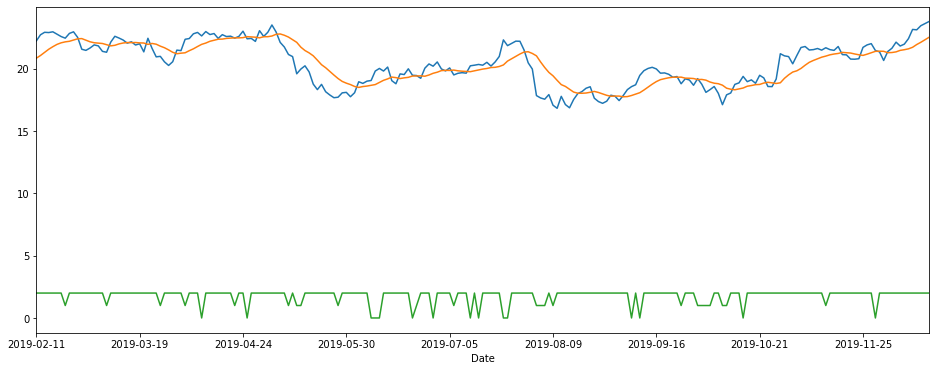

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

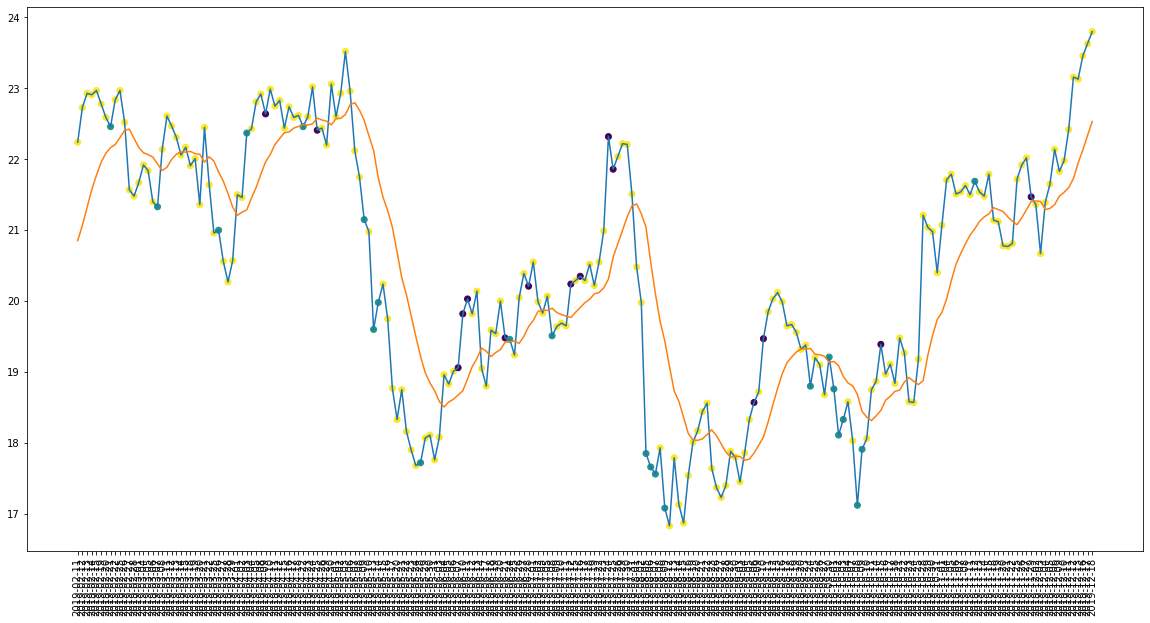

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

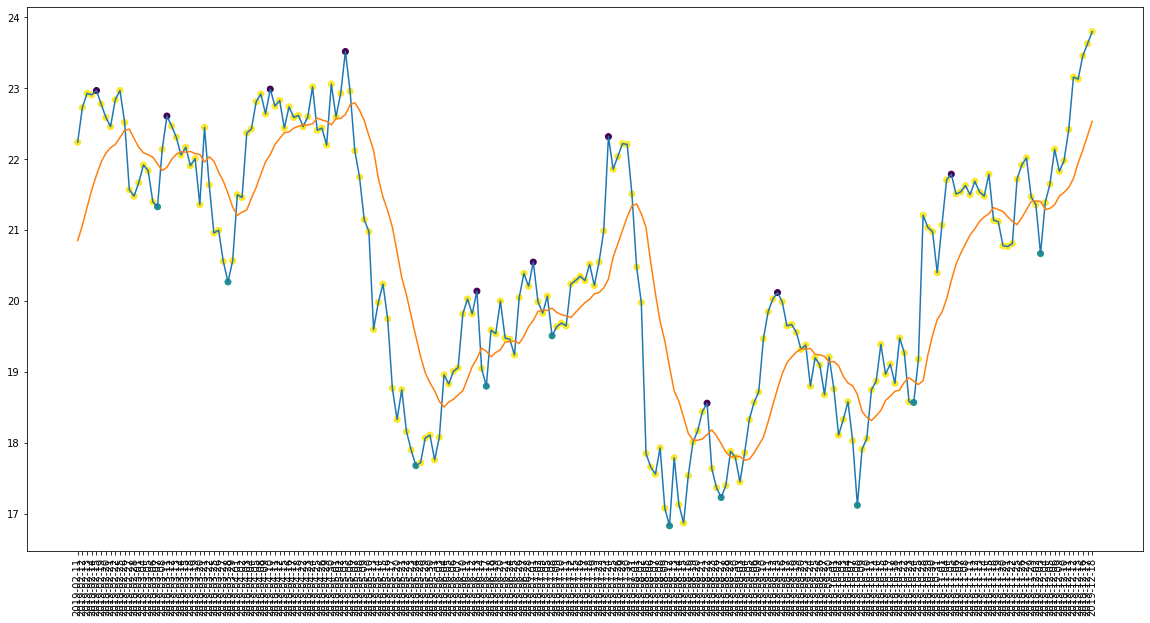

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 20
actual holds but predicted sell: 14
actual predicted holds: 164
Percentage buys correct: 30.0%
Percentage sells correct: 10.0%
Percentage holds correct: 82.82828282828282%
actual buys: 10
actual sells: 10
actual holds: 198
[22.239999771118164, 22.459999084472656, 22.59000015258789, 22.729999542236328, 22.78000068664551, 22.84000015258789, 22.90999984741211, 22.93000030517578, 22.96999931335449]
[21.479999542236328, 21.56999969482422, 21.670000076293945, 21.920000076293945, 22.459999084472656, 22.520000457763672, 22.59000015258789, 22.84000015258789, 22.96999931335449]
Percentage buys correct: 65.21739130434783%
Percentage sells correct: 40.0%
Percentage holds correct: 83.79888268156425%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $22.459999084472656
Shares owned at the moment: 444
Cash capital at the moment: $0.3367476119983621


Stop Loss Activated!

Share price: $21.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9551.079642486571


Share price: $21.32999992370605
Shares owned at the moment: 446
Cash capital at the moment: $11.738431607247549


Stop Loss Activated!

Share price: $20.559999465942386
Shares owned at the moment: 0
Cash capital at the moment: $9156.281354072573


Share price: $22.3700008392334
Shares owned at the moment: 408
Cash capital at the moment: $4.22187072372617


Stop Loss Activated!

Share price: $21.75
Shares owned at the moment: 0
Cash capital at the moment: $8853.818370723726


Share price: $21.149999618530273
Shares owned at the moment: 417
Cash capital at the moment: $10.01476773405193


Stop Loss Activated!

Share price: $19.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $8160.738626369477


Share price: $19.6000003

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10642.158481964114
profit gained: 6.421584819641139%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,0.0%,10.0%,80.3030303030303%,41.1764705882353%,56.52173913043478%,83.05084745762711%,-21.51396943860532%,6.421584819641139%
1,0.703196,9.090909090909092%,10.0%,76.76767676767676%,45.833333333333336%,55.55555555555556%,82.63473053892216%,51.19968491929272%,46.573979937162385%
2,0.770642,30.0%,10.0%,82.82828282828282%,65.21739130434783%,40.0%,83.79888268156425%,-5.69069425634385%,6.421584819641139%


### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


In [114]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,58.240002,58.725183,-61.538439,1540100.0,2.0
2020-01-23,58.349998,58.667462,-58.718007,9664600.0,2.0
2020-01-24,57.480000,58.484776,-78.606952,-334600.0,2.0
2020-01-27,57.730000,58.368656,-72.388048,10067600.0,2.0
2020-01-28,55.259998,57.890401,-96.415824,392100.0,2.0


In [115]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2020-01-22,24.790001,24.846573,-58.549170,15793400.0,2.0,58.240002
2020-01-23,24.799999,24.839408,-58.031122,19314300.0,2.0,58.349998
2020-01-24,25.469999,24.936422,-23.316098,25250200.0,2.0,57.480000
2020-01-27,24.990000,24.944665,-48.186537,19824200.0,2.0,57.730000
2020-01-28,23.660000,24.747024,-96.170207,12158200.0,2.0,55.259998


In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/ON_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1273 - accuracy: 0.8037 - mean_squared_error: 2.4421 - weighted_accuracy: 0.8037 - weighted_mean_squared_error: 2.4421
Test loss: 0.1272546947002411
Test accuracy: 0.8036529421806335


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 19, 2: 187, 0: 13})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 11})

In [123]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,21.400000,21.887629,-80.763353,-38050800.0,2.0,1,2
2020-02-12,21.389999,21.812609,-67.633600,-29835300.0,2.0,2,2
2020-02-13,21.629999,21.747592,-67.786276,-35158900.0,0.0,2,0
2020-02-14,21.440001,21.729501,-53.280337,-29027400.0,2.0,2,2
2020-02-18,21.110001,21.684962,-57.057647,-34656200.0,2.0,2,2


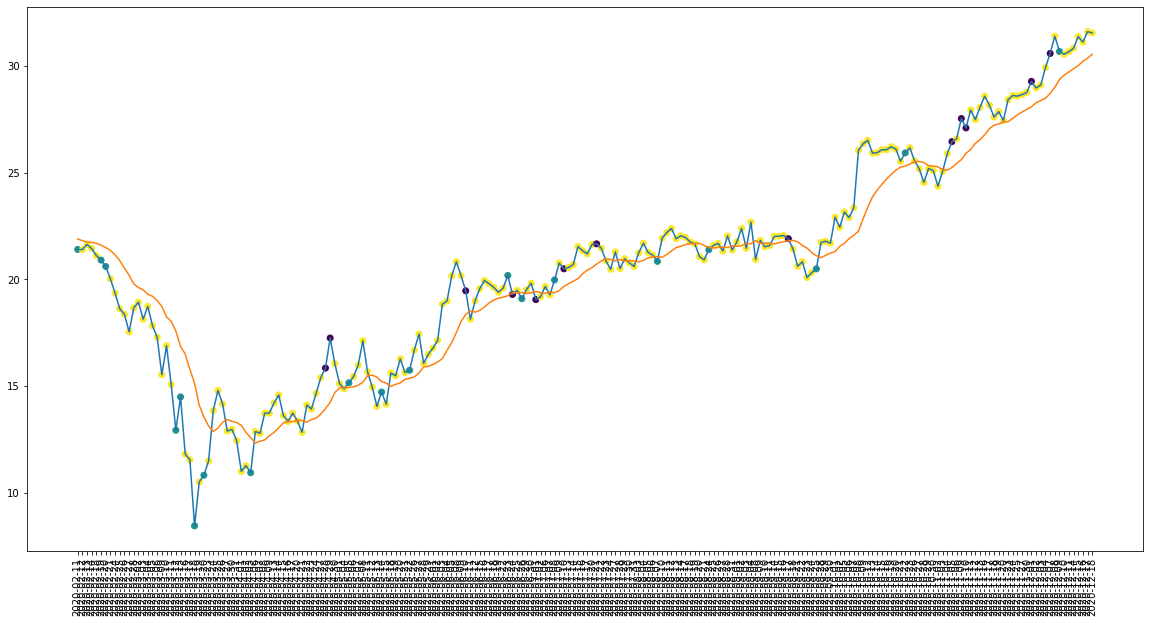

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

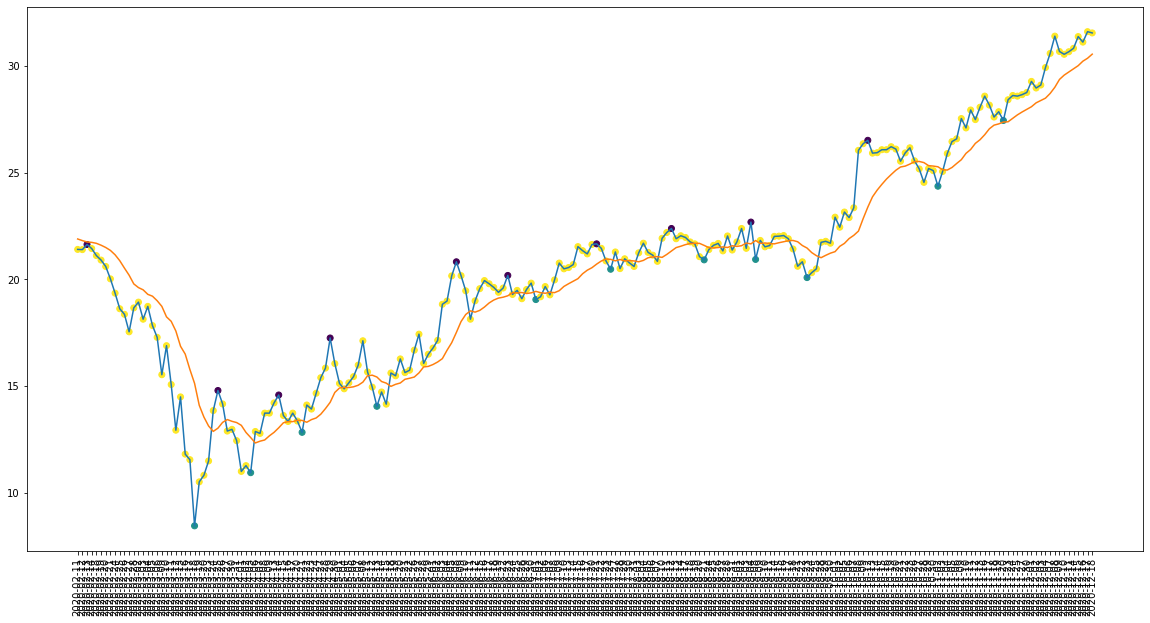

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 10
actual predicted holds: 172
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 20.0%
Percentage holds correct: 86.86868686868686%
actual buys: 11
actual sells: 10
actual holds: 198
[19.350000381469727, 20.020000457763672, 20.600000381469727, 20.899999618530273, 21.11000061035156, 21.38999938964844, 21.399999618530273, 21.440000534057614, 21.6299991607666]
[17.540000915527347, 18.1299991607666, 18.36000061035156, 18.6200008392334, 18.65999984741211, 18.93000030517578, 19.350000381469727, 20.020000457763672, 20.600000381469727]
Percentage buys correct: 57.89473684210526%
Percentage sells correct: 53.84615384615385%
Percentage holds correct: 84.40860215053763%


In [128]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $21.399999618530273
Shares owned at the moment: 466
Cash capital at the moment: $0.17607825374579988


Stop Loss Activated!

Share price: $20.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9573.377355529785


Share price: $20.600000381469727
Shares owned at the moment: 463
Cash capital at the moment: $9.348228423594264


Stop Loss Activated!

Share price: $20.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9253.117974785326


Share price: $12.93000030517578
Shares owned at the moment: 713
Cash capital at the moment: $8.67525909662254


Stop Loss Activated!

Share price: $11.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $8406.049099960564


Share price: $8.449999809265138
Shares owned at the moment: 992
Cash capital at the moment: $0.5976896898719133


Price increase from previously bought: 86.94153810903%
Share price: $15.84000015258789
Shares owned at the moment: 0
Cash capital at the moment:

In [129]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $14657.397993716238
profit gained: 46.573979937162385%


In [130]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,0.0%,10.0%,80.3030303030303%,41.1764705882353%,56.52173913043478%,83.05084745762711%,-21.51396943860532%,6.421584819641139%
1,0.703196,9.090909090909092%,10.0%,76.76767676767676%,45.833333333333336%,55.55555555555556%,82.63473053892216%,51.19968491929272%,46.573979937162385%
2,0.770642,30.0%,10.0%,82.82828282828282%,65.21739130434783%,40.0%,83.79888268156425%,-5.69069425634385%,6.421584819641139%
3,0.803653,18.181818181818183%,20.0%,86.86868686868686%,57.89473684210526%,53.84615384615385%,84.40860215053763%,116.8963754268239%,46.573979937162385%


In [131]:
experiment

'ON Variation 6 CNN Images Experiment'

In [132]:
log.to_csv('{}.csv'.format(experiment))